## Data

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
from sklearn.metrics import accuracy_score
from datetime import datetime, timedelta
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def get_training_test_data(stock='GOOG', start='2022-1-1', end='2025-01-31', training_ratio=0.96):
    df = yf.Ticker(stock).history(start=start, end=end)
    df = df.iloc[:,:-3]
    df.reset_index(inplace=True)
    df['Date'] = [i.date() for i in df.Date]
    df['fcc'] = [np.sign(df.Close.loc[i+1]-df.Close.loc[i]) for i in range(len(df)-1)]+[np.nan]
    training_length = int(len(df)*training_ratio)
    training_data = df.iloc[:training_length,:].round(2)
    test_data = df.iloc[training_length:,:]
    test_data.reset_index(inplace=True, drop=True)
    return (training_data, test_data)

In [3]:
df_train, df_test = get_training_test_data()
df_train.head()

,Date,Open,High,Low,Close,fcc
0,2022-01-03,143.49,144.56,142.53,144.09,-1.0
1,2022-01-04,144.56,145.61,142.84,143.43,-1.0
2,2022-01-05,143.20,143.32,136.59,136.72,-1.0
3,2022-01-06,136.56,138.74,135.83,136.62,-1.0
4,2022-01-07,136.97,137.32,134.87,136.07,1.0






## Encoding



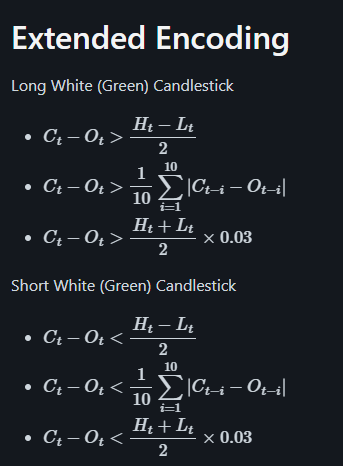

In [4]:
def get_prev_closes_opens(data,i,k):
  start_index = max(0, i-k)
  prev_closes = data['Close'].iloc[start_index:i]
  prev_opens = data['Open'].iloc[start_index:i]

  return prev_closes, prev_opens


In [5]:
def ex_encoder(hp, op, cp, lp,data,i,k=10,t=0.03):


    if hp  > op > cp  > lp:

      prev_closes, prev_opens = get_prev_closes_opens(data,i,k)

      length = (hp - lp) / 2
      avg_movement = sum([abs(close - open) for close, open in zip(prev_closes, prev_opens)]) / k
      threshold = (hp + lp) / 2 * t


      if (op - cp > length) and (op - cp > avg_movement) and (op - cp > threshold):
        return 'aL'
      elif (op - cp < length) and (op - cp < avg_movement) and (op - cp < threshold):
        return 'aS'
      else:
        return 'aM'


    if hp == op > cp  > lp: return 'b'
    if hp == op > cp == lp: return 'c'
    if hp  > op > cp == lp: return 'd'

    if hp  > cp > op  > lp:

      prev_closes, prev_opens = get_prev_closes_opens(data,i,k)
      length = (hp - lp) / 2
      avg_movement = sum([abs(close - open) for close, open in zip(prev_closes, prev_opens)]) / k
      threshold = (hp + lp) / 2 * t


      if (cp - op > length) and (cp - op > avg_movement) and (cp - op > threshold):
        return 'eL'
      elif (cp - op < length) and (cp - op < avg_movement) and (cp - op < threshold):
        return 'eS'
      else:
        return 'eM'

    if hp == cp > op  > lp: return 'f'
    if hp == cp > op == lp: return 'g'
    if hp  > cp > op == lp: return 'h'

    if hp  > op == cp  > lp: return 'i'
    if hp == op == cp  > lp: return 'j'
    if hp == op == cp == lp: return 'k'
    if hp  > op == cp == lp: return 'l'

In [6]:
def encoder(hp, op, cp, lp):
    if hp  > op > cp  > lp: return 'a'
    if hp == op > cp  > lp: return 'b'
    if hp == op > cp == lp: return 'c'
    if hp  > op > cp == lp: return 'd'

    if hp  > cp > op  > lp: return 'e'
    if hp == cp > op  > lp: return 'f'
    if hp == cp > op == lp: return 'g'
    if hp  > cp > op == lp: return 'h'

    if hp  > op == cp  > lp: return 'i'
    if hp == op == cp  > lp: return 'j'
    if hp == op == cp == lp: return 'k'
    if hp  > op == cp == lp: return 'l'

In [7]:
def ex_df_encoder(data,k,t):
    data_ = data.copy()
    encoder_list = []
    for i in data_.index:
        hp, op, cp, lp = data_[['High','Open', 'Close', 'Low']].loc[i]
        encoder_list.append(ex_encoder(hp, op, cp, lp,data,i,k=k,t=t))
    data_['code'] = encoder_list
    return data_

In [8]:
def df_encoder(data):
    data_ = data.copy()
    encoder_list = []
    for i in data_.index:
        hp, op, cp, lp = data_[['High','Open', 'Close', 'Low']].loc[i]
        encoder_list.append(encoder(hp, op, cp, lp))
    data_['code'] = encoder_list
    return data_

In [9]:
k = 10
t=0.03
df_train = ex_df_encoder(df_train,k,t)
df_train

,Date,Open,High,Low,Close,fcc,code
0,2022-01-03,143.49,144.56,142.53,144.09,-1.0,eM
1,2022-01-04,144.56,145.61,142.84,143.43,-1.0,aM
2,2022-01-05,143.20,143.32,136.59,136.72,-1.0,aL
3,2022-01-06,136.56,138.74,135.83,136.62,-1.0,eS
4,2022-01-07,136.97,137.32,134.87,136.07,1.0,aM
...,...,...,...,...,...,...,...
736,2024-12-06,173.12,176.07,172.79,175.72,1.0,eM
737,2024-12-09,175.15,177.47,174.83,176.53,1.0,eM
738,2024-12-10,183.94,187.42,182.08,185.93,1.0,eM
739,2024-12-11,186.10,196.25,185.66,196.08,-1.0,eL


## Change Point


In [10]:
def change_points(data):
    data_ = data.copy()
    change_pts, change_types = [True], ['Start']

    for i in range(1, len(data_)-1):

        left_change  = int(np.sign(data_['Close'][i]-data_['Close'][i-1]))
        right_change = int(np.sign(data_['Close'][i+1]-data_['Close'][i]))

        if left_change != right_change:
            change_pts.append(True)
        else:
            change_pts.append(False)

        change_types.append((left_change, right_change))

    change_pts.append(False)
    change_types.append('End')

    data_['change_points'] = change_pts
    data_['change_types'] = change_types

    return data_

In [11]:
df_train = change_points(df_train)
df_train.head()

,Date,Open,High,Low,Close,fcc,code,change_points,change_types
0,2022-01-03,143.49,144.56,142.53,144.09,-1.0,eM,True,Start
1,2022-01-04,144.56,145.61,142.84,143.43,-1.0,aM,False,"(-1, -1)"
2,2022-01-05,143.20,143.32,136.59,136.72,-1.0,aL,False,"(-1, -1)"
3,2022-01-06,136.56,138.74,135.83,136.62,-1.0,eS,False,"(-1, -1)"
4,2022-01-07,136.97,137.32,134.87,136.07,1.0,aM,True,"(-1, 1)"


## Segmentation and Labeling

In [12]:
def ex_segmentation(data):
    segment_list, trend_list = [], []
    pattern = []

    for i in range(len(data)-1):
        pattern.append(data.code[i])
        if data.change_points.loc[i]:
            segment_list.append(','.join(pattern))  # Join list into a string
            j = i
            while True:
                if data.change_types[j+1][0] != 0:
                    trend_list.append(data.change_types[j+1][0])
                    break
                j += 1
            pattern = []

    df_seg = pd.DataFrame()
    df_seg['kts'] = segment_list  # kts now contains strings instead of lists
    df_seg['trend'] = trend_list

    df_seg_unique = pd.DataFrame(df_seg.value_counts()).reset_index()

    return df_seg_unique


In [13]:
def segmentation(data):
    segment_list, trend_list = [], []
    pattern = ''

    for i in range(len(data)-1):
        pattern += data.code[i]

        if data.change_points.loc[i]:
            segment_list.append(pattern)
            j = i
            while True:
                if data.change_types[j+1][0] != 0:   # first non-equal direction
                    trend_list.append(data.change_types[j+1][0])
                    break
                j += 1

            pattern = ''

    df_seg = pd.DataFrame()
    df_seg['kts'] = segment_list
    df_seg['trend'] = trend_list

    df_seg_unique = pd.DataFrame(df_seg.value_counts()).reset_index()

    return df_seg_unique

In [14]:
PSet = ex_segmentation(df_train)
PSet

,kts,trend,count
0,aM,1,37
1,eM,-1,33
2,aS,1,25
3,eS,-1,19
4,aS,-1,14
...,...,...,...
134,"f,eS",-1,1
135,"h,eM",-1,1
136,"h,eS",-1,1
137,"h,eS,eM",-1,1


## Subsequence

In [15]:
# def ex_whethersub(X, Y):
#     X = X.split(',')
#     Y = Y.split(',')
#     if len(X) > len(Y):
#         return 0
#     else:
#         k = 0
#         for x in X:

#             if x in Y[k:]:

#                 k = Y.index(x, k) + 1
#             else:
#                 return 0
#     return 1


In [16]:
def whethersub(X,Y):
    if ',' in Y or ',' in X:
        X = X.split(',')
        Y = Y.split(',')
        if len(X) > len(Y):
            return 0
        else:
            k = 0
            for x in X:

                if x in Y[k:]:

                    k = Y.index(x, k) + 1
                else:
                    return 0
        return 1
    else:
        if len(X) > len(Y): return 0
        else:
            k = 0
            for i in range(len(X)):
                if X[i] in Y[k:]:
                    k = Y.find(X[i], k)+1
                else:
                    return 0
        return 1


In [17]:
whethersub('eL', 'eL,aS,eM,aS,eL')

1

## ONum

In [18]:
def onum(pset):
    pset_ = pset.copy()
    onum_list = []
    for i in range(len(pset)):
        total = 0
        for j in range(len(pset)):
            total += whethersub(pset_.loc[i, 'kts'], pset_.loc[j, 'kts'])* pset_.loc[j, 'count']
        onum_list.append(total)
    pset_['onum'] = onum_list
    return pset_

In [19]:
PRSet = onum(PSet)
PRSet

,kts,trend,count,onum
0,aM,1,37,118
1,eM,-1,33,127
2,aS,1,25,125
3,eS,-1,19,137
4,aS,-1,14,125
...,...,...,...,...
134,"f,eS",-1,1,1
135,"h,eM",-1,1,3
136,"h,eS",-1,1,4
137,"h,eS,eM",-1,1,2


## sameTrendNum

In [20]:
def sametrendnum(pset):
    pset_ = pset.copy()
    sametrendnum_list = []
    for i in range(len(pset_)):
        total = 0
        for j in range(len(pset_)):
            if whethersub(pset_.loc[i,'kts'], pset_.loc[j,'kts']) & (pset_.loc[i,'trend'] == pset_.loc[j, 'trend']):
                total += pset_.loc[j, 'count']
        sametrendnum_list.append(total)
    pset_['sametrendnum'] = sametrendnum_list
    return pset_

In [21]:
PRSet = sametrendnum(PRSet)
PRSet

,kts,trend,count,onum,sametrendnum
0,aM,1,37,118,106
1,eM,-1,33,127,112
2,aS,1,25,125,80
3,eS,-1,19,137,85
4,aS,-1,14,125,45
...,...,...,...,...,...
134,"f,eS",-1,1,1,1
135,"h,eM",-1,1,3,3
136,"h,eS",-1,1,4,4
137,"h,eS,eM",-1,1,2,2


##PACC

In [22]:
def pacc(pset):
    pset_ = pset.copy()
    pset_['pacc'] = (pset_['sametrendnum'] / pset_['onum']).round(4)
    return pset_

In [23]:
PRSet = pacc(PRSet)
PRSet

,kts,trend,count,onum,sametrendnum,pacc
0,aM,1,37,118,106,0.8983
1,eM,-1,33,127,112,0.8819
2,aS,1,25,125,80,0.6400
3,eS,-1,19,137,85,0.6204
4,aS,-1,14,125,45,0.3600
...,...,...,...,...,...,...
134,"f,eS",-1,1,1,1,1.0000
135,"h,eM",-1,1,3,3,1.0000
136,"h,eS",-1,1,4,4,1.0000
137,"h,eS,eM",-1,1,2,2,1.0000


## SubSequence Model

In [24]:
def subsequence_model_predict(kts, prset):
    best_pattern = []
    best_pacc = [0]
    best_trend = []
    for i in range(len(prset)):
        if (whethersub(prset.loc[i, 'kts'], kts)):
            if prset.loc[i, 'pacc'] > best_pacc[-1]:
                best_pattern = [prset.loc[i, 'kts']]
                best_pacc = [prset.loc[i,'pacc']]
                best_trend = [ prset.loc[i, 'trend']]
            elif prset.loc[i, 'pacc'] == best_pacc[-1]:
                best_pattern.append(prset.loc[i, 'kts'])
                best_pacc.append(prset.loc[i, 'pacc'])
                best_trend.append(prset.loc[i, 'trend'])

    if len(best_trend) == 0:
        pred = statistics.mode(prset.trend)
    elif len(best_trend) == 1:
        pred = best_trend[0]
    else:
        pred = statistics.mode(best_trend)

    return {'Best Pattern':best_pattern, 'Best PACC': best_pacc, 'Best Trend': best_trend, 'Prediction':pred}

In [25]:
subsequence_model_predict('eM,eM,eS,aM,aM', PRSet)

{'Best Pattern': ['eM,eM,eS', 'eM,aM,aM'],
 'Best PACC': [np.float64(1.0), np.float64(1.0)],
 'Best Trend': [-1, 1],
 'Prediction': -1}

## TestSet

In [26]:
k = 10
t=0.03
df_test = yf.Ticker('GOOG').history(start='2020-12-1', end='2020-12-30')
df_test.reset_index(inplace=True)
df_test = df_test.iloc[:,:-3]
df_test['Date'] = [i.date() for i in df_test.Date]
df_test = ex_df_encoder(df_test,k,t)
df_test['fcc'] = [np.sign(df_test.Close.loc[i+1]-df_test.Close.loc[i]) for i in range(len(df_test)-1)]+[np.nan]
df_test.head().round(2)

,Date,Open,High,Low,Close,code,fcc
0,2020-12-01,88.12,90.62,87.87,89.29,eM,1.0
1,2020-12-02,89.29,91.16,88.87,90.78,eM,-1.0
2,2020-12-03,90.58,91.73,90.51,90.72,eS,1.0
3,2020-12-04,90.61,91.04,90.23,90.78,eS,-1.0
4,2020-12-07,90.33,91.00,89.68,90.36,eS,-1.0


In [27]:
# def test_data_prep(data, N=5):
#     test_data = []
#     for i in range(len(data)-N):
#         kts = ''
#         for j in range(N):
#             kts += data.code.loc[i+j]
#         test_data.append((kts, data.fcc.loc[i+j]))

#     if type(test_data[-1][-1]) != float:
#         test_data.pop()

#     return test_data
def ex_test_data_prep(data, N=5):
    test_data = []
    for i in range(len(data) - N):
        kts = ''
        for j in range(N):
            # Append each character followed by a comma, except for the last one
            if j < N - 1:
                kts += data.code.loc[i+j] + ','
            else:
                kts += data.code.loc[i+j]

        # Append the formatted kts and the associated trend to test_data
        test_data.append((kts, float(data.fcc.loc[i+j])))

    # Validate the last item to ensure it has the correct type for the trend
    if type(test_data[-1][-1]) != float:
        test_data.pop()

    return test_data[:-1]



In [28]:
def test_data_prep(data, N=5):
    test_data = []
    for i in range(len(data)-N):
        kts = ''
        for j in range(N):
            kts += data.code.loc[i+j]
        test_data.append((kts, data.fcc.loc[i+j]))

    if type(test_data[-1][-1]) != float:
        test_data.pop()

    return test_data

In [29]:
df_test

,Date,Open,High,Low,Close,code,fcc
0,2020-12-01,88.115501,90.621356,87.867201,89.293938,eM,1.0
1,2020-12-02,89.293927,91.158669,88.865508,90.776283,eM,-1.0
2,2020-12-03,90.580635,91.732254,90.513096,90.717697,eS,1.0
3,2020-12-04,90.605954,91.035017,90.232017,90.778275,eS,-1.0
4,2020-12-07,90.331836,90.995795,89.675333,90.355675,eS,-1.0
5,2020-12-08,89.889857,90.475851,89.199832,90.309486,eM,-1.0
6,2020-12-09,89.984704,91.090138,87.789726,88.600174,aM,-1.0
7,2020-12-10,87.888552,88.460141,86.424572,88.163177,eS,1.0
8,2020-12-11,87.553851,88.616086,87.401891,88.482994,eM,-1.0
9,2020-12-14,88.146786,89.258676,87.263578,87.404861,aM,1.0


In [30]:
test_data = ex_test_data_prep(df_test)
test_data

[('eM,eM,eS,eS,eS', -1.0),
 ('eM,eS,eS,eS,eM', -1.0),
 ('eS,eS,eS,eM,aM', -1.0),
 ('eS,eS,eM,aM,eS', 1.0),
 ('eS,eM,aM,eS,eM', -1.0),
 ('eM,aM,eS,eM,aM', 1.0),
 ('aM,eS,eM,aM,eS', -1.0),
 ('eS,eM,aM,eS,aM', -1.0),
 ('eM,aM,eS,aM,aM', -1.0),
 ('aM,eS,aM,aM,aM', 1.0),
 ('eS,aM,aM,aM,eM', -1.0),
 ('aM,aM,aM,eM,aS', 1.0),
 ('aM,aM,eM,aS,eS', 1.0),
 ('aM,eM,aS,eS,eS', 1.0)]

## Prediction

In [31]:
def subsequence_model_score(data, prset):
    pred_trend_test = [subsequence_model_predict(kts, prset)['Prediction'] for (kts,trend) in data]
    actual_trend_test = [trend for (kts,trend) in data]
    return round(accuracy_score(pred_trend_test,  actual_trend_test),4)

In [32]:
subsequence_model_score(test_data, PRSet)

0.6429

In [33]:
def ex_pred_score(stock,k,t,startdate='2022-1-1', enddate='2025-01-31'):
    df_train, df_test = get_training_test_data(stock=stock, start=startdate, end=enddate)
    df_train = ex_df_encoder(df_train,k,t)
    df_train = change_points(df_train)
    PSet = ex_segmentation(df_train)
    PRSet = pacc(sametrendnum(onum(PSet)))
    df_test = ex_df_encoder(df_test,k,t)
    test_data = ex_test_data_prep(df_test)
    pred_score = subsequence_model_score(test_data, PRSet)
    return pred_score

In [34]:
def original_pred_score(stock, startdate='2022-1-1', enddate='2025-01-31'):
    df_train, df_test = get_training_test_data(stock=stock, start=startdate, end=enddate)
    df_train = df_encoder(df_train)
    df_train = change_points(df_train)
    PSet = segmentation(df_train)
    PRSet = pacc(sametrendnum(onum(PSet)))
    df_test = df_encoder(df_test)
    test_data = test_data_prep(df_test)
    pred_score = subsequence_model_score(test_data, PRSet)
    return pred_score

In [35]:

def sp500_symbols():
    df_sp = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

    symbol_list = df_sp['Symbol'].to_list()

    for symbol in symbol_list:
        if '.' in symbol:
            ind = symbol_list.index(symbol)
            symbol_list[ind] = symbol.replace('.','-')

    return symbol_list




In [36]:
# symbol_list = sp500_symbols()


# # columns = ['Stock', 'Paper Version'] + [f'Extended Version (t={t/100000})' for t in range(1, 20, 2)]
# columns = ['Stock', 'Paper Version'] + [f'Extended Version (k = 1,t=0.0101)']
# df_result = pd.DataFrame(columns=columns)
# i = 0


# for stock in symbol_list:
#     try:
#         i += 1
#         print(str(i) + '/' + str(len(symbol_list)))
#         original_score = original_pred_score(stock)
#         # extended_scores = [ex_pred_score(stock, t/100000)  for t in range(1, 20, 2)]
#         extended_scores = [ex_pred_score(stock, k =1 , t = 0.0101)]



#         df_result.loc[len(df_result)] = [stock, original_score] + extended_scores

#     except Exception as e:
#       print(f"Error processing {stock}: {e}")




In [37]:
# df_result.to_csv('/content/drive/My Drive/Sai Kaung San - MA905/data_files/o_v_ex_k_3t_0.00001_0.002.csv', index=False)

In [ ]:
df_result

In [ ]:

df_result.to_csv('/content/drive/My Drive/Sai Kaung San - MA905/data_files/best_score_k1_20_t0.00001_0.07[36:]c.csv', index=False)